In [33]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle
from ydata_profiling import ProfileReport


# Load the dataset
data = pd.read_csv("../datasets/ransomware.csv")

In [34]:
# Keep only highly correlated features
selected_columns = [
    'Benign', 'DebugSize', 'BitcoinAddresses', 'ExportSize', 'DebugRVA', 'ExportRVA',
    'DllCharacteristics', 'MajorLinkerVersion', 'Machine', 'MajorImageVersion',
    'MajorOSVersion', 'SizeOfStackReserve'
]
data = data[selected_columns]

In [35]:
# Save the cleaned dataset as df_clear
data.to_csv("../datasets/df_clear.csv", index=False)

In [36]:
# Separating features and labels
X = data.drop(columns=['Benign']).values  # Exclude 'Benign' from features
y = data['Benign'].values  # Use 'Benign' as the label
feature_names = data.columns[:-1]  # Column names except the label

In [37]:
# Splitting the dataset into two halves
X_half1, X_half2, y_half1, y_half2 = train_test_split(X, y, test_size=0.5, random_state=42)

In [38]:
# Splitting the first half: 70% Train, 30% Test
X_train, X_test, y_train, y_test = train_test_split(X_half1, y_half1, test_size=0.3, random_state=42)

In [39]:
# Splitting the second half into three validation sets
X_val1, X_temp, y_val1, y_temp = train_test_split(X_half2, y_half2, test_size=0.6667, random_state=42)  # 10k Val1
X_val2, X_val3, y_val2, y_val3 = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)  # 10k Val2, 10k Val3

In [40]:
# Train the Random Forest model with further reduced complexity to lower accuracy
best_model = RandomForestClassifier(n_estimators=3, max_depth=1, min_samples_split=50, min_samples_leaf=25, class_weight='balanced')
best_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=1,
                       min_samples_leaf=25, min_samples_split=50,
                       n_estimators=3)

In [41]:
# Save the best model to a .pkl file
with open("rf_ransomware_new.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file) 

In [42]:
# Evaluate model accuracy
score = best_model.score(X_test, y_test)
print(f"Model Accuracy: {score * 100:.2f}%")

Model Accuracy: 83.82%


In [43]:
# Make predictions and plot confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate', 'Ransomware'],
            yticklabels=['Legitimate', 'Ransomware'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig("confusion_matrix.png")
plt.close()

In [44]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.87      0.86      5215
           1       0.83      0.79      0.81      4158

    accuracy                           0.84      9373
   macro avg       0.84      0.83      0.84      9373
weighted avg       0.84      0.84      0.84      9373



In [45]:
# Load the cleaned dataset and model
data = pd.read_csv("../datasets/df_clear.csv")
with open("rf_ransomware.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

In [47]:
# Validate on the three validation sets
def evaluate_validation_set(X_val, y_val, val_name):
    val_score = best_model.score(X_val, y_val)
    y_val_pred = best_model.predict(X_val)
    print(f"\n{val_name} Accuracy: {val_score * 100:.2f}%")
    print(f"Classification Report for {val_name}:")
    print(classification_report(y_val, y_val_pred))

In [48]:
evaluate_validation_set(X_val1, y_val1, "Validation Set 1")
evaluate_validation_set(X_val2, y_val2, "Validation Set 2")
evaluate_validation_set(X_val3, y_val3, "Validation Set 3")



Validation Set 1 Accuracy: 83.92%
Classification Report for Validation Set 1:
              precision    recall  f1-score   support

           0       0.85      0.88      0.86      5916
           1       0.83      0.79      0.81      4497

    accuracy                           0.84     10413
   macro avg       0.84      0.83      0.84     10413
weighted avg       0.84      0.84      0.84     10413


Validation Set 2 Accuracy: 83.87%
Classification Report for Validation Set 2:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      5942
           1       0.82      0.79      0.81      4473

    accuracy                           0.84     10415
   macro avg       0.84      0.83      0.83     10415
weighted avg       0.84      0.84      0.84     10415


Validation Set 3 Accuracy: 83.71%
Classification Report for Validation Set 3:
              precision    recall  f1-score   support

           0       0.85      0.87      0.86      5940


In [15]:
# Sample 1% of the data
sampled_data = data.sample(frac=0.01, random_state=42)

# Generate the profiling report
profile = ProfileReport(sampled_data, explorative=True)

# Save report to an HTML file
profile.to_file("ransomware_profile.html")

# Display report in a Jupyter Notebook (if applicable)
profile.to_notebook_iframe()

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 27.87it/s]


ModuleNotFoundError: No module named 'ipywidgets'

In [14]:
# Load the cleaned dataset and model
data = pd.read_csv("../datasets/df_clear.csv")
with open("rf_ransomware.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

In [15]:
# Get feature importances
importances = loaded_model.feature_importances_
feature_names = data.columns[:-1]  # Exclude the label column
indices = np.argsort(importances)[::-1]  # Sort by importance

In [16]:
# Save the top N features (e.g., top 111) to a .txt file
top_n = 15
top_features = feature_names[indices[:top_n]]
with open("top_features.txt", "w") as f:
    for feature in top_features:
        f.write(f"{feature}\n")

print(f"Top {top_n} features saved to top_features.txt")

Top 15 features saved to top_features.txt


Model Accuracy: 99.68%
Best parameters found:  {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}


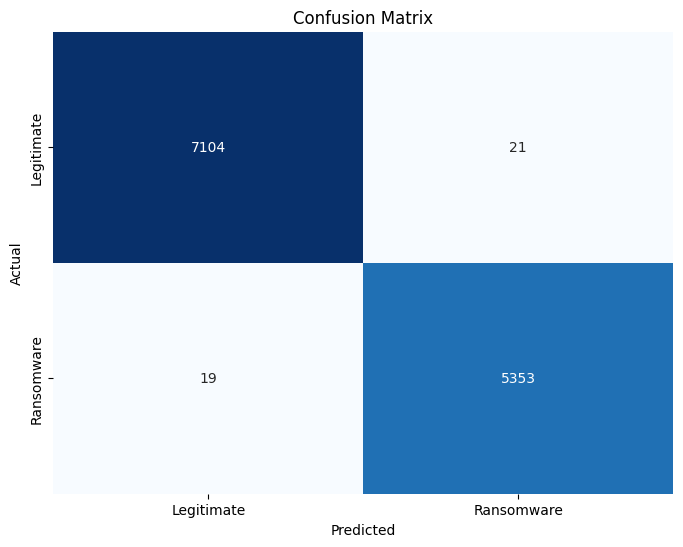


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7125
           1       1.00      1.00      1.00      5372

    accuracy                           1.00     12497
   macro avg       1.00      1.00      1.00     12497
weighted avg       1.00      1.00      1.00     12497



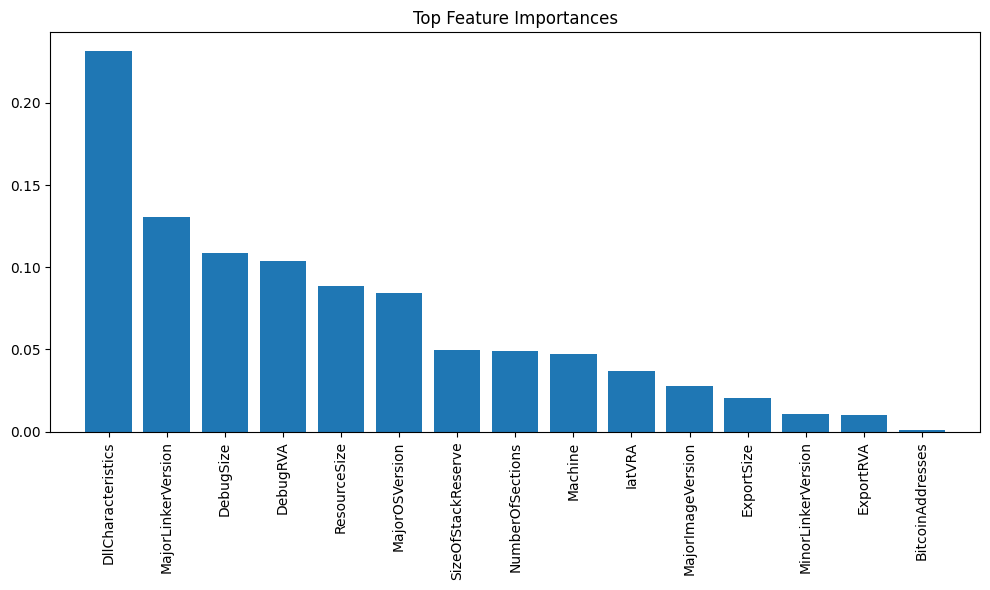

Top 15 features saved to top_features.txt


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
import pickle

# Load the dataset
data = pd.read_csv("../datasets/ransomware.csv")

# Drop the specified columns
data = data.drop(columns=['FileName', 'md5Hash'])

# Save the cleaned dataset as df_clear
data.to_csv("../datasets/df_clear.csv", index=False)

# Separating features and labels
X = data.iloc[:, :-1].values  # All rows, all columns except the last (label)
y = data.iloc[:, -1].values    # All rows, last column (label)
feature_names = data.columns[:-1]  # Column names except the last column

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_

# Save the best model to a .pkl file
with open("rf_ransomware.pkl", "wb") as model_file:
    pickle.dump(best_model, model_file) 

# Evaluate model accuracy
score = best_model.score(X_test, y_test)
print(f"Model Accuracy: {score * 100:.2f}%")
print("Best parameters found: ", grid_search.best_params_)

# Make predictions and plot confusion matrix
y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Legitimate', 'Ransomware'],
            yticklabels=['Legitimate', 'Ransomware'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Importances
importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]  # Sort features by importance

# Plot feature importances with feature names
plt.figure(figsize=(10, 6))
plt.title("Top Feature Importances")
plt.bar(range(len(feature_names)), importances[indices], align="center")
plt.xticks(range(len(feature_names)), feature_names[indices], rotation=90)
plt.xlim([-1, len(feature_names)])
plt.tight_layout()
plt.show()

# Load the cleaned dataset and model
data = pd.read_csv("../datasets/df_clear.csv")
with open("rf_ransomware.pkl", "rb") as model_file:
    loaded_model = pickle.load(model_file)

# Get feature importances
importances = loaded_model.feature_importances_
feature_names = data.columns[:-1]  # Exclude the label column
indices = np.argsort(importances)[::-1]  # Sort by importance

# Save the top N features (e.g., top 111) to a .txt file
top_n = 15
top_features = feature_names[indices[:top_n]]
with open("top_features.txt", "w") as f:
    for feature in top_features:
        f.write(f"{feature}\n")

print(f"Top {top_n} features saved to top_features.txt")
